In [1]:
import numpy as np
import scipy
from scipy.integrate import quad
from scipy.optimize import minimize

import astropy
from astropy.table import QTable
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

%matplotlib inline
import matplotlib.pyplot as plt

# Fit z-distribution of Candels catalog

Fit z-distribution to:

$$\frac{dN}{dz} \propto z^{\beta} \exp \left[-(\frac{z}{z_0})^\alpha \right]$$


$\beta$ is fixed to 2. I need to find $\alpha$, $z_0$ as a function of the H-band limit

In [14]:
n_arc = 668*u.arcminute*u.arcminute #This is the area of the candels survey included in this catalog
n_deg = n_arc.to(u.deg*u.deg).value

In [3]:
cluster_sample = "CANDELS_LSST+WFIRSTfilters_spec_new.fits"
cat = QTable.read(cluster_sample,1)

#Define selection criteria

mask = (cat['redshift'] > 0) & (cat['redshift'] < 4) & \
        (cat['cstar'] < 0.9) & ((cat['u_LSST']-cat['g_LSST'])<3.5) & \
        ((cat['g_LSST']-cat['r_LSST'])<3.5) & ((cat['r_LSST']-cat['i_LSST'])<3.5) & \
        ((cat['i_LSST']-cat['z_LSST'])<3.5) & ((cat['z_LSST']-cat['y_WFIRST'])<3.5) & \
        ((cat['y_WFIRST']-cat['j_WFIRST'])<3.5) & ((cat['j_WFIRST']-cat['h_WFIRST'])<3.5) & \
        ((cat['h_WFIRST']-cat['F184W_WFIRST'])<3.5) & ((cat['u_LSST']-cat['g_LSST'])>-2.5) & \
        ((cat['g_LSST']-cat['r_LSST'])>-2.5) & ((cat['r_LSST']-cat['i_LSST'])>-2.5) & \
        ((cat['i_LSST']-cat['z_LSST'])>-2.5) & ((cat['z_LSST']-cat['y_WFIRST'])>-2.5) & \
        ((cat['y_WFIRST']-cat['j_WFIRST'])>-2.5) & ((cat['j_WFIRST']-cat['h_WFIRST'])>-2.5) & \
        ((cat['h_WFIRST']-cat['F184W_WFIRST'])>-2.5) & \
        (cat['SNR']>5) & (cat['fwhm']>0)

cat = cat[mask].to_pandas()

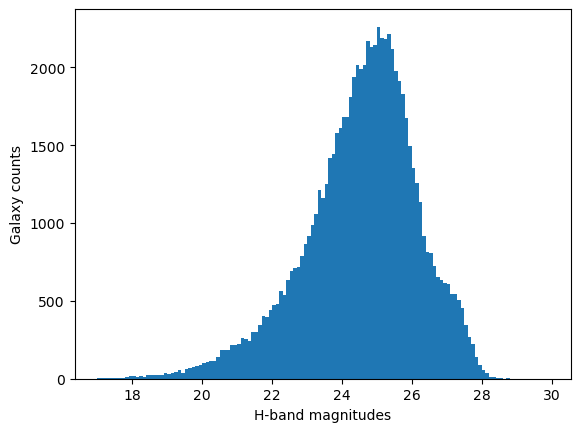

In [4]:
plt.hist(cat['h_WFIRST'],bins=np.arange(17,30,0.1))
plt.xlabel('H-band magnitudes')
plt.ylabel('Galaxy counts');

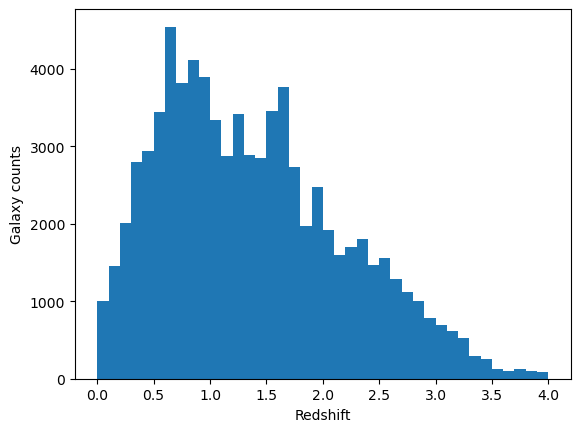

In [5]:
plt.hist(cat['redshift'],bins=np.arange(0,4.1,0.1))
plt.xlabel('Redshift')
plt.ylabel('Galaxy counts');

In [6]:
def get_sample(catalog,H_lim):
    z_sample = catalog[catalog['h_WFIRST']<H_lim]
    z_sample = z_sample[z_sample['redshift']<4]['redshift']
    n_tot = len(z_sample)
    return z_sample, n_tot

def redshift_pdf(z, z0, alpha):
    return z**2 * np.exp(-(z/z0)**alpha)

def normalization_factor(z0, alpha):
    result, _ = quad(lambda z: redshift_pdf(z, z0, alpha), 0, 4.)
    return result

def normalized_redshift_pdf(z, z0, alpha):
    norm = normalization_factor(z0, alpha)
    return redshift_pdf(z, z0, alpha) / norm

def neg_log_likelihood(params, data):
    z0, alpha = params
    # Avoiding log(0) by adding a small number inside the log
    likelihoods = normalized_redshift_pdf(data, z0, alpha) + 1e-10
    return -np.sum(np.log(likelihoods))

def fit_curve(redshift_data):
    initial_params = [0.15, 0.6] # Initial guesses for z0 and alpha
    bounds = [(0.01,4),(0.01,1)]
    result = minimize(neg_log_likelihood, initial_params,
                  args=(redshift_data,), bounds=bounds,
                     method='Nelder-Mead', tol=1e-6)
    z0_opt, b_opt = result.x
    print("Optimized parameters:")
    print("z0 =", z0_opt)
    print("alpha =", b_opt)
    return z0_opt, b_opt
    
def plot_curve(redshift_data,z0_opt,b_opt):
    # Histogram of the data
    plt.hist(redshift_data, bins=25, density=True, alpha=0.5,
             label='Data Histogram')

    # Values for plotting the fitted model
    z_values = np.linspace(0, max(redshift_data), 200)
    fitted_pdf = redshift_pdf(z_values, z0_opt, b_opt)
    
    # Normalizing the fitted PDF for comparison
    fitted_pdf /= (np.sum(fitted_pdf) * (z_values[1] - z_values[0]))
    
    plt.plot(z_values, fitted_pdf, label='Fitted Model')
    plt.xlabel('Redshift (z)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

Optimized parameters:
z0 = 0.128920522655826
alpha = 0.6719481618725696


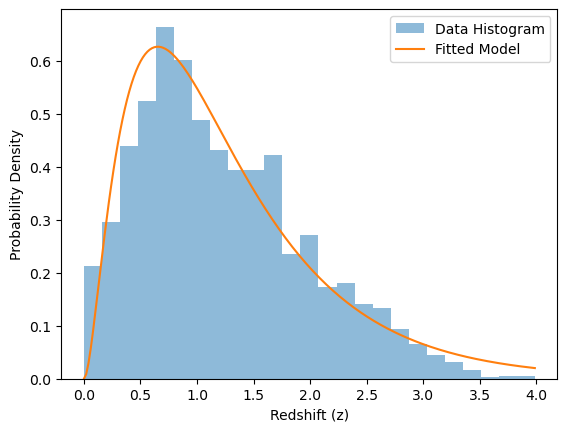

In [8]:
HLIM = 25 #This is where you set your magnitude cut

z_sample, n_tot = get_sample(cat,HLIM) #Apply the magnitude cut to your catalog

z0,alpha = fit_curve(z_sample) #Fit curve to magnitude limited sample

plot_curve(z_sample,z0,alpha)

In [9]:
n_eff = np.rint(np.array(n_tot)/n_arc) #Number of galaxies per square arcminute

## Split into Tomographic Bins \& Convolve with Gaussian photo-z uncertainty $\sigma_z(1+z)$

In [10]:
from scipy import special

def find_index_exceeding_value(array, value):
  for i, element in enumerate(array):
    if element > value:
      return i
  return -1

def find_bin_edges(tomo_bins,z,dndz,plot):
    bin_edges = [np.min(z)]
    current_threshold = 0
    tomo_limits = [ZMIN]
    index = [0]
    for i in range(tomo_bins):
        tomo_limits.append(z[find_index_exceeding_value(np.cumsum(dndz*dz), (i+1)/tomo_bins)])
        if i<tomo_bins-1:
            index.append(np.where(np.cumsum(dndz*dz) > (i+1)/tomo_bins)[0][0])
        else:
            index.append(len(dndz)-1)
        
    tomo_limits[-1] = ZMAX

    if plot:
        for i in range(tomo_bins):
            plt.fill_between(z[index[i]:index[i+1]], dndz[index[i]:index[i+1]], y2=0)
        plt.show()

    return tomo_limits

def sigma_z(z,sig_mag):
    sig_z=sig_mag*(1.0+z) 
    return sig_z

def delta_z(z,del_mag):
    del_z=del_mag*(1.0+z)
    return del_z


def conv_gaussian(z,dndz,tomo_limits,sig_mag,del_mag,plot):
    dndzconv=np.zeros((len(z), len(tomo_limits)-1))
    for k in range(len(tomo_limits)-1):
        for i in range(len(z)):
            x1 = (tomo_limits[k] - z[i] + delta_z(z[i],del_mag))/(np.sqrt(2.)*sigma_z(z[i],sig_mag))
            x2 = (tomo_limits[k+1] - z[i] + delta_z(z[i],del_mag))/(np.sqrt(2.)*sigma_z(z[i],sig_mag))
            dndzconv[i][k]=(0.5*dndz[i]*(special.erf(x2) - special.erf(x1)))
        n_integral = np.trapz(dndzconv[:,k],z) # get area under curve
        dndzconv[:,k] *= 1.0 / n_integral / (len(tomo_limits)-1) #re-normalize tomo-bins
        if plot:
            plt.plot(z, dndzconv[:,k], lw=2)
    if plot:
        plt.plot(z, dndz, 'black', lw=2, label=r'Roman Galaxy Sample')
        plt.show()
    return dndzconv

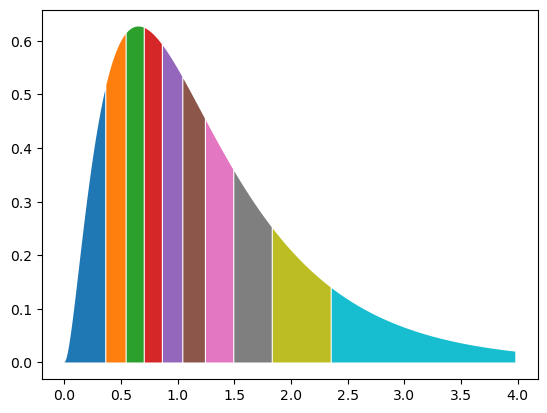

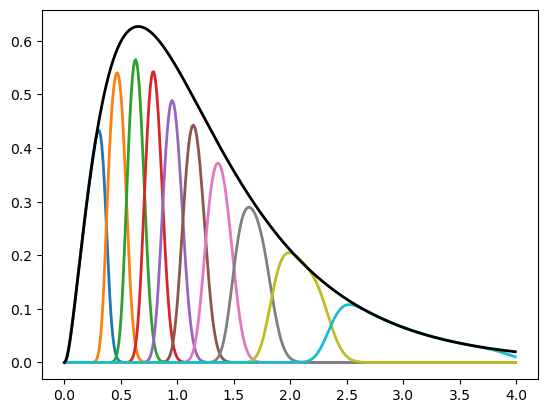

In [17]:
TOMO_BINS = 10
ZMIN = 0.0
ZMAX = 4.0
dz = 0.01
z = np.arange(ZMIN, ZMAX, dz)


SIG_Z_MAG = 0.03
DEL_Z_MAG = 0.00


dndz = normalized_redshift_pdf(z,z0,alpha)
tomo_limits = find_bin_edges(TOMO_BINS,z,dndz,True)
dndzconv = conv_gaussian(z,dndz,tomo_limits,SIG_Z_MAG,DEL_Z_MAG,True)

In [12]:
#Write z, n(z) to file
        
def save_nz(z,nz,path):
    zdist = np.swapaxes(np.vstack((z,nz)),0,1)
    np.savetxt(path, zdist)

In [13]:
filename = 'test'
save_nz(z,np.swapaxes(dndzconv,0,1),filename)